In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import sklearn
from tqdm import tqdm
import random
import copy

import data_interface
import mnar_blackout_lds

random.seed(42)
np.random.seed(42)

In [3]:
# Load the data
x_t, m_t, meta = data_interface.load_panel()

In [4]:
evaluation_windows = data_interface.get_eval_windows("data")

In [5]:
from collections import defaultdict

def stratified_month_sampling(data, n_per_month, ts_key="blackout_start"):
    buckets = defaultdict(list)

    for item in data:
        ts = item[ts_key]
        month_key = (ts.year, ts.month)
        buckets[month_key].append(item)

    result = []
    for month_key, items in buckets.items():
        if len(items) < n_per_month:
            picks = random.choices(items, k=n_per_month)
        else:
            picks = random.sample(items, n_per_month)
        result.extend(picks)

    return result


In [6]:
# ------------------------------------------------------------------
# 1) Group evaluation windows by window_id and test_type/horizon
#    (handles cases where there are multiple rows per window_id).
# ------------------------------------------------------------------
impute_by_id = {}
forecast_1_by_id = {}
forecast_3_by_id = {}
forecast_6_by_id = {}

for w in evaluation_windows:
    wid = w["window_id"]
    if w["test_type"] == "impute":
        # If duplicates exist, last one wins – that's fine for eval.
        impute_by_id[wid] = w
    elif w["test_type"] == "forecast":
        h = int(w["horizon_steps"])
        if h == 1:
            forecast_1_by_id[wid] = w
        elif h == 3:
            forecast_3_by_id[wid] = w
        elif h == 6:
            forecast_6_by_id[wid] = w


In [7]:
# ------------------------------------------------------------------
# 2) Keep only window_ids that have impute + 1-step + 3-step + 6-step
# ------------------------------------------------------------------
common_ids = (
    set(impute_by_id.keys())
    & set(forecast_1_by_id.keys())
    & set(forecast_3_by_id.keys())
    & set(forecast_6_by_id.keys())
)

# Pool of impute windows that have all matching forecast horizons
impute_windows_pool = [impute_by_id[wid] for wid in common_ids]

In [8]:
# ------------------------------------------------------------------
# 3) Sample *validation* impute windows (stratified by month)
# ------------------------------------------------------------------
impute_evaluation_windows_val = stratified_month_sampling(
    impute_windows_pool,
    n_per_month=25,
    ts_key="blackout_start",
)

# Preserve order: we now build *aligned* forecast lists
val_ids_ordered = [w["window_id"] for w in impute_evaluation_windows_val]

forecast_1_evaluation_windows_val = [
    forecast_1_by_id[wid] for wid in val_ids_ordered
]
forecast_3_evaluation_windows_val = [
    forecast_3_by_id[wid] for wid in val_ids_ordered
]
forecast_6_evaluation_windows_val = [
    forecast_6_by_id[wid] for wid in val_ids_ordered
]

In [9]:
assert len(forecast_1_evaluation_windows_val) == len(impute_evaluation_windows_val)
assert len(forecast_3_evaluation_windows_val) == len(impute_evaluation_windows_val)
assert len(forecast_6_evaluation_windows_val) == len(impute_evaluation_windows_val)

# ------------------------------------------------------------------
# 4) Combined list used only for masking (deduped later)
# ------------------------------------------------------------------
evaluation_windows_val = (
    forecast_1_evaluation_windows_val
    + forecast_3_evaluation_windows_val
    + forecast_6_evaluation_windows_val
    + impute_evaluation_windows_val
)

In [10]:
def locf_impute_baseline(x_t, start_idx, end_idx, detector_idx):
    """
    Naive 'last observation carried forward' baseline for imputation.
    Uses the last finite value before blackout; falls back to
    detector-wise historical mean if needed.
    """
    last_idx = start_idx - 1
    while last_idx >= 0 and not np.isfinite(x_t[last_idx, detector_idx]):
        last_idx -= 1

    if last_idx < 0:
        det_vals = x_t[:, detector_idx]
        last_val = float(np.nanmean(det_vals))
    else:
        last_val = float(x_t[last_idx, detector_idx])

    length = end_idx - start_idx + 1
    return np.full(length, last_val, dtype=float)


def locf_forecast_baseline(x_t, end_idx, detector_idx):
    """
    Naive baseline for forecasting: hold the last available observation
    at the end of the blackout.
    """
    last_idx = end_idx
    while last_idx >= 0 and not np.isfinite(x_t[last_idx, detector_idx]):
        last_idx -= 1

    if last_idx < 0:
        det_vals = x_t[:, detector_idx]
        last_val = float(np.nanmean(det_vals))
    else:
        last_val = float(x_t[last_idx, detector_idx])

    return last_val


def evaluate_impute_forecast_model(
    model,
    mu_smooth,
    Sigma_smooth,
    mu_filt,
    Sigma_filt,
    x_t,
    meta,
    label="model",
):
    """
    Re-usable evaluation for any LDS-like model (MAR or MNAR):
    - blackout imputation RMSE/MAE (length-weighted)
    - 1 / 3 / 6-step forecast RMSE/MAE
    """
    # ---------------- Imputation ----------------
    impute_mae_list = []
    impute_mse_list = []

    for window in impute_evaluation_windows_val:
        if window["test_type"] != "impute":
            continue

        start_idx = np.where(meta["timestamps"] == window["blackout_start"])[0][0]
        end_idx = np.where(meta["timestamps"] == window["blackout_end"])[0][0]
        detector_idx = np.where(meta["detectors"] == window["detector_id"])[0][0]

        eval_x_t = x_t[start_idx : end_idx + 1].copy()
        eval_mu_smooth = mu_smooth[start_idx : end_idx + 1]
        eval_Sigma_smooth = Sigma_smooth[start_idx : end_idx + 1]

        reconstruct_x_t, _ = model.reconstruct_from_smoother(
            eval_mu_smooth, eval_Sigma_smooth
        )

        y_true = eval_x_t[:, detector_idx]
        y_pred = reconstruct_x_t[:, detector_idx]

        mask = np.isfinite(y_true) & np.isfinite(y_pred)
        if not mask.any():
            continue

        mae = sklearn.metrics.mean_absolute_error(y_pred[mask], y_true[mask])
        mse = sklearn.metrics.mean_squared_error(y_pred[mask], y_true[mask])

        impute_mae_list.append([mae, window["len_steps"]])
        impute_mse_list.append([mse, window["len_steps"]])

    final_mae = np.average(
        [item[0] for item in impute_mae_list],
        weights=[item[1] for item in impute_mae_list],
    )
    final_mse = np.average(
        [item[0] for item in impute_mse_list],
        weights=[item[1] for item in impute_mse_list],
    )
    final_rmse = np.sqrt(final_mse)

    print(f"\n[{label}] Imputation performance:")
    print("  MAE :", final_mae)
    print("  MSE :", final_mse)
    print("  RMSE:", final_rmse)

    # ---------------- Forecasting ----------------
    y_actual_1_step, y_forecast_1_step = [], []
    y_actual_3_step, y_forecast_3_step = [], []
    y_actual_6_step, y_forecast_6_step = [], []

    forecast_evaluation_windows_val = (
        forecast_1_evaluation_windows_val
        + forecast_3_evaluation_windows_val
        + forecast_6_evaluation_windows_val
    )

    for window in forecast_evaluation_windows_val:
        if window["test_type"] != "forecast":
            continue

        start_idx = np.where(meta["timestamps"] == window["blackout_start"])[0][0]
        end_idx = np.where(meta["timestamps"] == window["blackout_end"])[0][0]
        detector_idx = np.where(meta["detectors"] == window["detector_id"])[0][0]
        horizon = int(window["horizon_steps"])

        # Skip windows too close to the end of the series
        if end_idx + horizon >= x_t.shape[0]:
            continue

        eval_x_t = x_t[end_idx + 1 : end_idx + 1 + horizon].copy()

        forecast_x_t, _ = model.k_step_forecast(
            mu_filt, Sigma_filt, end_idx, k=horizon
        )

        y_true = eval_x_t[horizon - 1, detector_idx]
        y_pred = forecast_x_t[detector_idx]

        if not (np.isfinite(y_true) and np.isfinite(y_pred)):
            continue

        if horizon == 1:
            y_forecast_1_step.append(y_pred)
            y_actual_1_step.append(y_true)
        elif horizon == 3:
            y_forecast_3_step.append(y_pred)
            y_actual_3_step.append(y_true)
        elif horizon == 6:
            y_forecast_6_step.append(y_pred)
            y_actual_6_step.append(y_true)

    mae_1_step = sklearn.metrics.mean_absolute_error(
        y_forecast_1_step, y_actual_1_step
    )
    mse_1_step = sklearn.metrics.mean_squared_error(
        y_forecast_1_step, y_actual_1_step
    )
    rmse_1_step = np.sqrt(mse_1_step)

    mae_3_step = sklearn.metrics.mean_absolute_error(
        y_forecast_3_step, y_actual_3_step
    )
    mse_3_step = sklearn.metrics.mean_squared_error(
        y_forecast_3_step, y_actual_3_step
    )
    rmse_3_step = np.sqrt(mse_3_step)

    mae_6_step = sklearn.metrics.mean_absolute_error(
        y_forecast_6_step, y_actual_6_step
    )
    mse_6_step = sklearn.metrics.mean_squared_error(
        y_forecast_6_step, y_actual_6_step
    )
    rmse_6_step = np.sqrt(mse_6_step)

    print(f"\n[{label}] Forecasting performance:")
    print("-----------------------------------")
    print("1-step MAE :", mae_1_step)
    print("1-step MSE :", mse_1_step)
    print("1-step RMSE:", rmse_1_step)

    print("\n-----------------------------------")
    print("3-step MAE :", mae_3_step)
    print("3-step MSE :", mse_3_step)
    print("3-step RMSE:", rmse_3_step)

    print("\n-----------------------------------")
    print("6-step MAE :", mae_6_step)
    print("6-step MSE :", mse_6_step)
    print("6-step RMSE:", rmse_6_step)

    return {
        "impute_mae": final_mae,
        "impute_mse": final_mse,
        "impute_rmse": final_rmse,
        "forecast_mae_1": mae_1_step,
        "forecast_mse_1": mse_1_step,
        "forecast_rmse_1": rmse_1_step,
        "forecast_mae_3": mae_3_step,
        "forecast_mse_3": mse_3_step,
        "forecast_rmse_3": rmse_3_step,
        "forecast_mae_6": mae_6_step,
        "forecast_mse_6": mse_6_step,
        "forecast_rmse_6": rmse_6_step,
    }

In [11]:
def evaluate_locf_baseline(
    x_t_true,
    x_t_masked,
    meta,
    label="LOCF baseline",
):
    """
    Baseline evaluation using LOCF for both imputation and forecasting.
    x_t_true   : full panel (no artificial masking), used ONLY for y_true
    x_t_masked : panel with blackout windows masked (same as training),
                 used for baseline predictions so it can't peek inside.
    """
    # ---------- Imputation ----------
    impute_mae_list = []
    impute_mse_list = []

    for window in impute_evaluation_windows_val:
        if window["test_type"] != "impute":
            continue

        start_idx = np.where(meta["timestamps"] == window["blackout_start"])[0][0]
        end_idx   = np.where(meta["timestamps"] == window["blackout_end"])[0][0]
        detector_idx = np.where(meta["detectors"] == window["detector_id"])[0][0]

        # Truth from full data
        y_true = x_t_true[start_idx : end_idx + 1, detector_idx].copy()

        # LOCF baseline only sees masked training panel
        y_pred = locf_impute_baseline(
            x_t_masked, start_idx, end_idx, detector_idx
        )

        mask = np.isfinite(y_true) & np.isfinite(y_pred)
        if not mask.any():
            continue

        mae = sklearn.metrics.mean_absolute_error(y_pred[mask], y_true[mask])
        mse = sklearn.metrics.mean_squared_error(y_pred[mask], y_true[mask])

        impute_mae_list.append([mae, window["len_steps"]])
        impute_mse_list.append([mse, window["len_steps"]])

    final_mae = np.average(
        [item[0] for item in impute_mae_list],
        weights=[item[1] for item in impute_mae_list],
    )
    final_mse = np.average(
        [item[0] for item in impute_mse_list],
        weights=[item[1] for item in impute_mse_list],
    )
    final_rmse = np.sqrt(final_mse)

    print(f"\n[{label}] Imputation performance:")
    print("  MAE :", final_mae)
    print("  MSE :", final_mse)
    print("  RMSE:", final_rmse)

    # ---------- Forecast ----------
    y_actual_1_step, y_forecast_1_step = [], []
    y_actual_3_step, y_forecast_3_step = [], []
    y_actual_6_step, y_forecast_6_step = [], []

    forecast_evaluation_windows_val = (
        forecast_1_evaluation_windows_val
        + forecast_3_evaluation_windows_val
        + forecast_6_evaluation_windows_val
    )

    for window in forecast_evaluation_windows_val:
        if window["test_type"] != "forecast":
            continue

        start_idx = np.where(meta["timestamps"] == window["blackout_start"])[0][0]
        end_idx   = np.where(meta["timestamps"] == window["blackout_end"])[0][0]
        detector_idx = np.where(meta["detectors"] == window["detector_id"])[0][0]
        horizon = int(window["horizon_steps"])

        if end_idx + horizon >= x_t_true.shape[0]:
            continue

        # Truth from full data
        y_true = x_t_true[end_idx + horizon, detector_idx]

        # Baseline sees ONLY masked panel (so it uses last observed pre-blackout)
        y_pred = locf_forecast_baseline(
            x_t_masked, end_idx, detector_idx
        )

        if not (np.isfinite(y_true) and np.isfinite(y_pred)):
            continue

        if horizon == 1:
            y_forecast_1_step.append(y_pred)
            y_actual_1_step.append(y_true)
        elif horizon == 3:
            y_forecast_3_step.append(y_pred)
            y_actual_3_step.append(y_true)
        elif horizon == 6:
            y_forecast_6_step.append(y_pred)
            y_actual_6_step.append(y_true)

    mae_1_step = sklearn.metrics.mean_absolute_error(
        y_forecast_1_step, y_actual_1_step
    )
    mse_1_step = sklearn.metrics.mean_squared_error(
        y_forecast_1_step, y_actual_1_step
    )
    rmse_1_step = np.sqrt(mse_1_step)

    mae_3_step = sklearn.metrics.mean_absolute_error(
        y_forecast_3_step, y_actual_3_step
    )
    mse_3_step = sklearn.metrics.mean_squared_error(
        y_forecast_3_step, y_actual_3_step
    )
    rmse_3_step = np.sqrt(mse_3_step)

    mae_6_step = sklearn.metrics.mean_absolute_error(
        y_forecast_6_step, y_actual_6_step
    )
    mse_6_step = sklearn.metrics.mean_squared_error(
        y_forecast_6_step, y_actual_6_step
    )
    rmse_6_step = np.sqrt(mse_6_step)

    print(f"\n[{label}] Forecasting performance:")
    print("-----------------------------------")
    print("1-step MAE :", mae_1_step)
    print("1-step MSE :", mse_1_step)
    print("1-step RMSE:", rmse_1_step)

    print("\n-----------------------------------")
    print("3-step MAE :", mae_3_step)
    print("3-step MSE :", mse_3_step)
    print("3-step RMSE:", rmse_3_step)

    print("\n-----------------------------------")
    print("6-step MAE :", mae_6_step)
    print("6-step MSE :", mse_6_step)
    print("6-step RMSE:", rmse_6_step)

    return {
        "impute_mae": final_mae,
        "impute_mse": final_mse,
        "impute_rmse": final_rmse,
        "forecast_mae_1": mae_1_step,
        "forecast_mse_1": mse_1_step,
        "forecast_rmse_1": rmse_1_step,
        "forecast_mae_3": mae_3_step,
        "forecast_mse_3": mse_3_step,
        "forecast_rmse_3": rmse_3_step,
        "forecast_mae_6": mae_6_step,
        "forecast_mse_6": mse_6_step,
        "forecast_rmse_6": rmse_6_step,
    }

In [12]:
def mask_evaluation_windows(x_t, m_t, evaluation_windows_val, meta):
    x_t_masked = x_t.copy()
    m_t_masked = m_t.copy()

    # Deduplicate (detector, start, end) so we don't re-mask the same block many times
    unique_blocks = set()
    for window in evaluation_windows_val:
        start_ts = window["blackout_start"]
        end_ts = window["blackout_end"]
        det_id = window["detector_id"]
        unique_blocks.add((start_ts, end_ts, det_id))

    for (start_ts, end_ts, det_id) in unique_blocks:
        start_idx = np.where(meta["timestamps"] == start_ts)[0][0]
        end_idx = np.where(meta["timestamps"] == end_ts)[0][0]
        detector_idx = np.where(meta["detectors"] == det_id)[0][0]

        x_t_masked[start_idx:end_idx+1, detector_idx] = np.nan
        m_t_masked[start_idx:end_idx+1, detector_idx] = 1

    return x_t_masked, m_t_masked

In [14]:
# Prepare training data by masking evaluation windows
x_t_train, m_t_train = mask_evaluation_windows(x_t, m_t, evaluation_windows_val, meta)
latent_dim = 12
D = x_t_train.shape[1]

### Need to compare the effect of number of latent states.
### And then fix the number of latents to the one which gives very less error.
### See how the Data likelihood improves over iterations
### Finally, show the MSE comparison across LOCF, MAR, MNAR

In [ ]:
mar_model_list = []
mar_history_list = []
mnar_model_list = []
mnar_history_list = []

for latent_k in range(3, 21, 3):
    latent_dim = latent_k
    print(f"\n=== Training models with latent_dim = {latent_dim} ===")
    # # ---------------- MAR model (no phi updates) ----------------
    # mar_params = mnar_blackout_lds.MNARParams.init_random(K=latent_dim, D=D, seed=42)
    # model_mar = mnar_blackout_lds.MNARBlackoutLDS(mar_params)
    # em_train_history_mar = model_mar.em_train(
    #     x_t_train,
    #     m_t_train,
    #     num_iters=7,
    #     update_phi=False,  # MAR: ignore missingness mechanism
    #     phi_steps=0,
    #     phi_lr=0.0,
    #     verbose=True,
    #     convergence_tol=1e-3,
    # )
    # mar_model_list.append(copy.deepcopy(model_mar))
    # mar_history_list.append(em_train_history_mar)

    # ---------------- MNAR model (warm-start from MAR) ----------------
    mnar_params = mnar_blackout_lds.MNARParams.init_random(K=latent_dim, D=D, seed=42)
    model_mnar = mnar_blackout_lds.MNARBlackoutLDS(mnar_params)
    em_train_history_mnar = model_mnar.em_train(
        x_t_train,
        m_t_train,
        num_iters=7,
        update_phi=True,   # MNAR: learn missingness mechanism
        phi_steps=2,
        phi_lr=1e-4,
        verbose=True,
        convergence_tol=1e-3,
    )
    mnar_model_list.append(copy.deepcopy(model_mnar))
    mnar_history_list.append(em_train_history_mnar)


=== Training models with latent_dim = 3 ===

=== EM iteration 1/7 ===
  A norm: 1.712
  Q trace: 1.067
  mean diag(R): 598.453
  Log-likelihood (obs. data): -6141629831.429

=== EM iteration 2/7 ===
  A norm: 1.325
  Q trace: 1.283
  mean diag(R): 68.193
  max relative param change: 4.048e-01
  Log-likelihood (obs. data): -61404230.760

=== EM iteration 3/7 ===
  A norm: 1.592
  Q trace: 1.204
  mean diag(R): 47.537
  max relative param change: 4.062e-01
  Log-likelihood (obs. data): -49418215.951

=== EM iteration 4/7 ===
  A norm: 1.702
  Q trace: 0.475
  mean diag(R): 39.328
  max relative param change: 9.750e-02
  Log-likelihood (obs. data): -46844738.235

=== EM iteration 5/7 ===
  A norm: 1.715
  Q trace: 0.311
  mean diag(R): 38.536
  max relative param change: 2.319e-02
  Log-likelihood (obs. data): -46276918.491

=== EM iteration 6/7 ===
  A norm: 1.718
  Q trace: 0.266
  mean diag(R): 38.457
  max relative param change: 1.112e-02
  Log-likelihood (obs. data): -46223214.599



In [18]:
latent_mse_list = [[34.07071264240028,49.38940331946848, 32.85826444699398, 34.62865004851894]]
for model in mnar_model_list[1:]:
    sample_ekf_mnar = model.ekf_forward(x_t_train, m_t_train)
    sample_smoother_mnar = model.rts_smoother(sample_ekf_mnar)

    mu_filt_mnar = sample_ekf_mnar["mu_filt"]
    Sigma_filt_mnar = sample_ekf_mnar["Sigma_filt"]
    mu_smooth_mnar = sample_smoother_mnar["mu_smooth"]
    Sigma_smooth_mnar = sample_smoother_mnar["Sigma_smooth"]

    metrics_mnar = evaluate_impute_forecast_model(
        model=model,
        mu_smooth=mu_smooth_mnar,
        Sigma_smooth=Sigma_smooth_mnar,
        mu_filt=mu_filt_mnar,
        Sigma_filt=Sigma_filt_mnar,
        x_t=x_t,
        meta=meta,
        label="MNAR LDS",
    )
    latent_mse_list.append([metrics_mnar["impute_mse"], metrics_mnar["forecast_mse_1"],
                             metrics_mnar["forecast_mse_3"], metrics_mnar["forecast_mse_6"]])



[MNAR LDS] Imputation performance:
  MAE : 3.4774505036624164
  MSE : 22.532891137516756
  RMSE: 4.746882254439934

[MNAR LDS] Forecasting performance:
-----------------------------------
1-step MAE : 4.528196428057118
1-step MSE : 38.77666505439297
1-step RMSE: 6.227091219373053

-----------------------------------
3-step MAE : 3.302203552768442
3-step MSE : 27.419759595281903
3-step RMSE: 5.236388029480045

-----------------------------------
6-step MAE : 3.9491437374457687
6-step MSE : 35.552238411708714
6-step RMSE: 5.96256978254416

[MNAR LDS] Imputation performance:
  MAE : 2.8813611479688945
  MSE : 17.98657133640564
  RMSE: 4.241057808661141

[MNAR LDS] Forecasting performance:
-----------------------------------
1-step MAE : 3.9428353130814897
1-step MSE : 34.65328534846184
1-step RMSE: 5.886704115926147

-----------------------------------
3-step MAE : 3.0244422715699666
3-step MSE : 25.658241109448387
3-step RMSE: 5.065396441488898

-----------------------------------
6-ste

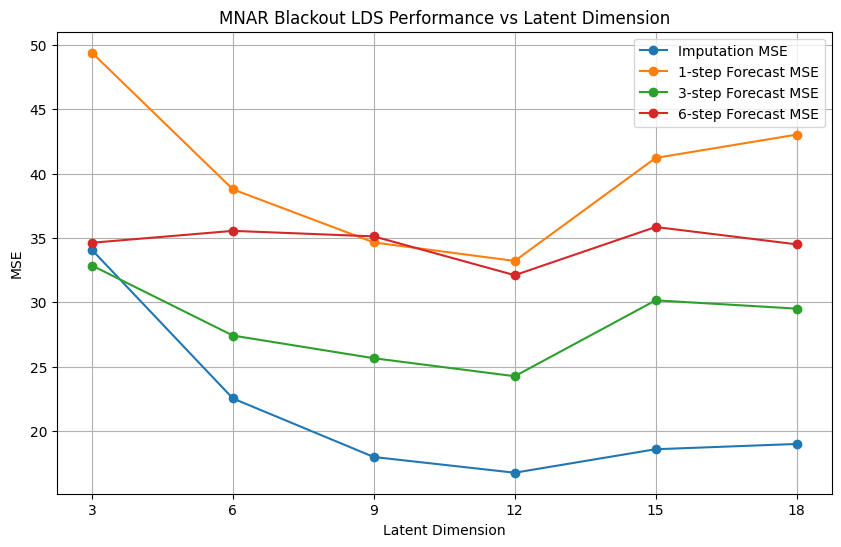

In [19]:
import matplotlib.pyplot as plt

latent_dims = list(range(3, 21, 3))
impute_mse_values = [item[0] for item in latent_mse_list]
forecast_mse_1_values = [item[1] for item in latent_mse_list]
forecast_mse_3_values = [item[2] for item in latent_mse_list]
forecast_mse_6_values = [item[3] for item in latent_mse_list]
plt.figure(figsize=(10, 6))
plt.plot(latent_dims, impute_mse_values, marker='o', label='Imputation MSE')
plt.plot(latent_dims, forecast_mse_1_values, marker='o', label='1-step Forecast MSE')
plt.plot(latent_dims, forecast_mse_3_values, marker='o', label='3-step Forecast MSE')
plt.plot(latent_dims, forecast_mse_6_values, marker='o', label='6-step Forecast MSE')
plt.xlabel('Latent Dimension')
plt.ylabel('MSE')
plt.title('MNAR Blackout LDS Performance vs Latent Dimension')
plt.xticks(latent_dims)
plt.legend()
plt.grid()
plt.show()

In [20]:
latent_dim = 20
print(f"\n=== Training models with latent_dim = {latent_dim} ===")
# ---------------- MAR model (no phi updates) ----------------
mar_params = mnar_blackout_lds.MNARParams.init_random(K=latent_dim, D=D, seed=42)
model_mar = mnar_blackout_lds.MNARBlackoutLDS(mar_params)
em_train_history_mar = model_mar.em_train(
    x_t_train,
    m_t_train,
    num_iters=15,
    update_phi=False,  # MAR: ignore missingness mechanism
    phi_steps=0,
    phi_lr=0.0,
    verbose=True,
    convergence_tol=1e-3,
)

# ---------------- MNAR model (warm-start from MAR) ----------------
mnar_params = mnar_blackout_lds.MNARParams.init_random(K=latent_dim, D=D, seed=42)
model_mnar = mnar_blackout_lds.MNARBlackoutLDS(mnar_params)
em_train_history_mnar = model_mnar.em_train(
    x_t_train,
    m_t_train,
    num_iters=15,
    update_phi=True,   # MNAR: learn missingness mechanism
    phi_steps=2,
    phi_lr=1e-4,
    verbose=True,
    convergence_tol=1e-3,
)


=== Training models with latent_dim = 20 ===

=== EM iteration 1/15 ===
  A norm: 4.337
  Q trace: 7.881
  mean diag(R): 37.813
  Log-likelihood (obs. data): -5852435753.187

=== EM iteration 2/15 ===
  A norm: 4.008
  Q trace: 18.677
  mean diag(R): 23.175
  max relative param change: 3.892e-01
  Log-likelihood (obs. data): -47154897.258

=== EM iteration 3/15 ===
  A norm: 4.073
  Q trace: 20.289
  mean diag(R): 20.152
  max relative param change: 1.582e-01
  Log-likelihood (obs. data): -42961728.779

=== EM iteration 4/15 ===
  A norm: 4.121
  Q trace: 18.224
  mean diag(R): 19.327
  max relative param change: 1.014e-01
  Log-likelihood (obs. data): -42204746.650

=== EM iteration 5/15 ===
  A norm: 4.150
  Q trace: 16.083
  mean diag(R): 19.042
  max relative param change: 8.219e-02
  Log-likelihood (obs. data): -41938073.250

=== EM iteration 6/15 ===
  A norm: 4.168
  Q trace: 14.362
  mean diag(R): 18.924
  max relative param change: 6.490e-02
  Log-likelihood (obs. data): -417

### Reconstruction and Prediction

In [21]:
ekf_mar = model_mar.ekf_forward(x_t_train, m_t_train)
smoother_mar = model_mar.rts_smoother(ekf_mar)

mu_filt_mar = ekf_mar["mu_filt"]
Sigma_filt_mar = ekf_mar["Sigma_filt"]
mu_smooth_mar = smoother_mar["mu_smooth"]
Sigma_smooth_mar = smoother_mar["Sigma_smooth"]

metrics_mar = evaluate_impute_forecast_model(
    model=model_mar,
    mu_smooth=mu_smooth_mar,
    Sigma_smooth=Sigma_smooth_mar,
    mu_filt=mu_filt_mar,
    Sigma_filt=Sigma_filt_mar,
    x_t=x_t,
    meta=meta,
    label="MAR LDS",
)


[MAR LDS] Imputation performance:
  MAE : 3.006857216364333
  MSE : 20.218901022624372
  RMSE: 4.496543230374236

[MAR LDS] Forecasting performance:
-----------------------------------
1-step MAE : 5.15448273520417
1-step MSE : 50.323592772034075
1-step RMSE: 7.09391237414405

-----------------------------------
3-step MAE : 4.3005142191694725
3-step MSE : 37.76115494307341
3-step RMSE: 6.145010573064411

-----------------------------------
6-step MAE : 4.763224051844458
6-step MSE : 46.57648633143722
6-step RMSE: 6.824696794102814


In [22]:
# ---------------- Reconstruction & prediction: MNAR ----------------
ekf_mnar = model_mnar.ekf_forward(x_t_train, m_t_train)
smoother_mnar = model_mnar.rts_smoother(ekf_mnar)

mu_filt_mnar = ekf_mnar["mu_filt"]
Sigma_filt_mnar = ekf_mnar["Sigma_filt"]
mu_smooth_mnar = smoother_mnar["mu_smooth"]
Sigma_smooth_mnar = smoother_mnar["Sigma_smooth"]

metrics_mnar = evaluate_impute_forecast_model(
    model=model_mnar,
    mu_smooth=mu_smooth_mnar,
    Sigma_smooth=Sigma_smooth_mnar,
    mu_filt=mu_filt_mnar,
    Sigma_filt=Sigma_filt_mnar,
    x_t=x_t,
    meta=meta,
    label="MNAR LDS",
)


[MNAR LDS] Imputation performance:
  MAE : 3.2750614511375256
  MSE : 24.380562476454454
  RMSE: 4.937667716286147

[MNAR LDS] Forecasting performance:
-----------------------------------
1-step MAE : 4.48895221622796
1-step MSE : 43.43282606411813
1-step RMSE: 6.590358568706116

-----------------------------------
3-step MAE : 3.502701244748694
3-step MSE : 30.064201608857513
3-step RMSE: 5.48308322104065

-----------------------------------
6-step MAE : 3.97781569399351
6-step MSE : 37.756744939246865
6-step RMSE: 6.144651734577548


In [23]:
# ---------------- Baseline: LOCF ----------------
baseline_locf_metrics = evaluate_locf_baseline(
    x_t_true=x_t,
    x_t_masked=x_t_train,
    meta=meta,
    label="LOCF baseline",
)

print("\nDone: LOCF vs MAR vs MNAR evaluated on the same blackout windows.")


[LOCF baseline] Imputation performance:
  MAE : 3.701672288083485
  MSE : 24.841926859359603
  RMSE: 4.984167619508758

[LOCF baseline] Forecasting performance:
-----------------------------------
1-step MAE : 4.762612556501439
1-step MSE : 48.416818803912086
1-step RMSE: 6.958219513921078

-----------------------------------
3-step MAE : 4.177777069165959
3-step MSE : 31.36509333346946
3-step RMSE: 5.60045474345338

-----------------------------------
6-step MAE : 4.033777534055315
6-step MSE : 27.962783569499322
6-step RMSE: 5.2879848306797665

Done: LOCF vs MAR vs MNAR evaluated on the same blackout windows.


In [31]:
em_train_history_mar["log_likelihood"][0] = -5852435753.187 

Saving animation... (this might take a moment)
Done! Saved as 'em_training_progression.gif'


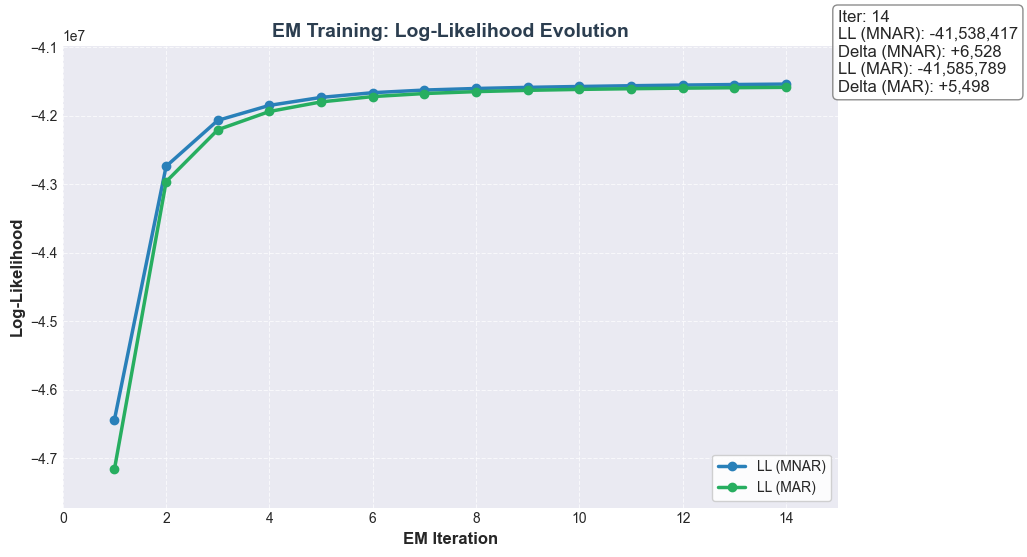

In [33]:
# --------------------------------------
# --- Log-Likelihoods on training data
# --------------------------------------
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# --- 1. SETUP DATA (Replace this with your real training history) ---
# Simulating a typical EM curve: fast rise, then plateau
n_iterations = 14
iterations = np.arange(1, n_iterations + 1)
ll_history_mnar = em_train_history_mnar["log_likelihood"][1:]
ll_history_mar = em_train_history_mar["log_likelihood"][1:]


# --- 2. SETUP THE PLOT STYLE ---
plt.style.use('seaborn-v0_8-darkgrid') # Or 'ggplot' if seaborn is not found
fig, ax = plt.subplots(figsize=(10, 6))

# Set fixed limits so the axes don't jump around
all_values = ll_history_mnar + ll_history_mar
y_min = min(all_values)
y_max = max(all_values)
y_padding = (y_max - y_min) * 0.1  # 10% margin
ax.set_xlim(0, n_iterations + 1)
ax.set_ylim(y_min - y_padding, y_max + y_padding)

# Labels and Title
ax.set_xlabel('EM Iteration', fontsize=12, fontweight='bold')
ax.set_ylabel('Log-Likelihood', fontsize=12, fontweight='bold')
ax.set_title('EM Training: Log-Likelihood Evolution', fontsize=14, fontweight='bold', color='#2c3e50')
ax.grid(True, linestyle='--', alpha=0.7)

# Initialize the plot elements we will update
line1, = ax.plot([], [], color='#2980b9', linewidth=2.5, marker='o', markersize=6, label='LL (MNAR)')
line2, = ax.plot([], [], color='#27ae60', linewidth=2.5, marker='o', markersize=6, label='LL (MAR)')

# --- THE FIX: Add the legend so we know which line is which ---
ax.legend(loc='lower right', frameon=True, facecolor='white', framealpha=0.9)

# A text box to show current stats
text_display = ax.text(1.0, 0.9, '', transform=ax.transAxes, fontsize=12, 
                       bbox=dict(facecolor='white', alpha=0.9, edgecolor='gray', boxstyle='round'))

# --- 3. ANIMATION LOGIC ---
def init():
    """Initial state of the animation."""
    line1.set_data([], [])
    line2.set_data([], [])
    text_display.set_text('')
    return line1, line2, text_display

def update(frame):
    """Update function for frame i."""
    # frame is the index (0 to n-1)
    
    # Get data up to current frame
    x = iterations[:frame+1]
    y1 = ll_history_mnar[:frame+1]
    y2 = ll_history_mar[:frame+1]
    
    # Update the line
    line1.set_data(x, y1)
    line2.set_data(x, y2)
    
    # Calculate "Delta" (improvement since last step)
    if frame > 0:
        improvement1 = y1[-1] - y1[-2]
        improvement2 = y2[-1] - y2[-2]
        msg = f'Iter: {x[-1]}\nLL (MNAR): {y1[-1]:,.0f}\nDelta (MNAR): +{improvement1:,.0f}\nLL (MAR): {y2[-1]:,.0f}\nDelta (MAR): +{improvement2:,.0f}'
    else:
        msg = f'Iter: {x[-1]}\nLL (MNAR): {y1[-1]:,.0f}\nLL (MAR): {y2[-1]:,.0f}\nStarting...'
        
    text_display.set_text(msg)
    
    return line1, line2, text_display

# --- 4. CREATE AND SAVE ---
# frames=len(iterations) ensures we loop through all data points
ani = animation.FuncAnimation(fig, update, frames=len(iterations), 
                              init_func=init, blit=True, interval=100)

# Save as GIF (requires Pillow, which is standard)
print("Saving animation... (this might take a moment)")
ani.save('em_training_progression.gif', writer='pillow', fps=10)
print("Done! Saved as 'em_training_progression.gif'")

plt.show()

In [28]:
ll_history_mar

[np.float64(-47154897.25789965),
 np.float64(-47154897.25789965),
 np.float64(-42961728.77860556),
 np.float64(-42204746.64984236),
 np.float64(-41938073.2501789),
 np.float64(-41798403.04897354),
 np.float64(-41720585.38966845),
 np.float64(-41676166.71807351),
 np.float64(-41648381.63996022),
 np.float64(-41629526.93502577),
 np.float64(-41615967.530825876),
 np.float64(-41605767.01195444),
 np.float64(-41597782.5417216),
 np.float64(-41591286.9553586),
 np.float64(-41585788.610255904)]

In [30]:
em_train_history_mar["log_likelihood"]

[np.float64(-47154897.25789965),
 np.float64(-47154897.25789965),
 np.float64(-42961728.77860556),
 np.float64(-42204746.64984236),
 np.float64(-41938073.2501789),
 np.float64(-41798403.04897354),
 np.float64(-41720585.38966845),
 np.float64(-41676166.71807351),
 np.float64(-41648381.63996022),
 np.float64(-41629526.93502577),
 np.float64(-41615967.530825876),
 np.float64(-41605767.01195444),
 np.float64(-41597782.5417216),
 np.float64(-41591286.9553586),
 np.float64(-41585788.610255904)]